In [11]:
import torch
from transformers import BertTokenizer, BertModel
import csv
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Function to read CSV file and extract columns
def read_csv(file_path):
    columns = {}
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for column in reader.fieldnames:
            columns[column] = []
        for row in reader:
            for column in reader.fieldnames:
                columns[column].append(row[column])
    return columns

def split_response(input):
    input = "\\n\\n1)" + input[34:-57]

    result = re.split(r'\\n\\n\d\)', input)
    for i in range(len(result)):
        result[i] = re.split(r'(\\n\d\.\d\d?|\\n\d\.\d)', result[i])

    for i in range(len(result)):
        indicesToRemove = []
        for j in range(len(result[i])):
            if len(result[i][j]) < 8:
                indicesToRemove.append(j)
        indicesToRemove.reverse()
        for j in indicesToRemove:
            result[i].remove(result[i][j])
    return result[1:]



In [26]:
gpt_separate = read_csv("C:/Users/laela/Downloads/Separate_Pairs_FINAL_Result_wGPT.csv")["GPT"]
cagpt_separate = read_csv("C:/Users/laela/Downloads/Separate_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]
gpt_mixed = read_csv("C:/Users/laela/Downloads/Mixed_Pairs_FINAL_Result_wGPT.csv")["GPT"]
cagpt_mixed= read_csv("C:/Users/laela/Downloads/Mixed_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

gpt = gpt_separate #+ gpt_mixed
cagpt = cagpt_separate #+ cagpt_mixed

# Define function to obtain BERT embeddings
def get_bert_embeddings(tokenized_input):
    with torch.no_grad():
        outputs = model(**tokenized_input)
        # Consider the output of the [CLS] token as the embedding for the entire sequence
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.numpy()

# Initialize lists to store BERT embeddings
gpt_embeddings = [[],[],[],[],[]]
cagpt_embeddings = [[],[],[],[],[]]

for i in range(len(gpt)):
    gpt[i] = split_response(gpt[i])

for i in range(len(cagpt)):
    cagpt[i] = split_response(cagpt[i])

while i < len(gpt):
    if len(gpt[i]) != 5:
        gpt.remove(gpt[i])
        i = i-1
    i+=1

for i in range(len(cagpt)):
    if len(cagpt[i]) != 5:
        cagpt.remove(cagpt[i])
        i = i-1
    if i+1 == len(cagpt):
        break

# Process tokenized inputs and obtain BERT embeddings for 'gpt'
for i in tqdm(range(len(gpt))):
    for question in range(len(gpt[i])):
        for subquestion in range(len(gpt[i][question])):
            tokenized_inputs = [tokenizer.encode_plus(gpt[i][question][subquestion], add_special_tokens=True, truncation=True, max_length=256, return_tensors='pt', padding=True) ]
            embeddings = [get_bert_embeddings(tokenized_input) for tokenized_input in tokenized_inputs]
            gpt_embeddings[question].append(embeddings)


# Process tokenized inputs and obtain BERT embeddings for 'cagpt'
for i in tqdm(range(len(cagpt))):
    for question in range(len(cagpt[i])):
        for subquestion in range(len(cagpt[i][question])):
            tokenized_inputs = [tokenizer.encode_plus(cagpt[i][question][subquestion], add_special_tokens=True, truncation=True, max_length=256, return_tensors='pt', padding=True)]
            embeddings = [get_bert_embeddings(tokenized_input) for tokenized_input in tokenized_inputs]
            cagpt_embeddings[question].append(embeddings)


100%|██████████| 230/230 [02:59<00:00,  1.28it/s]


In [27]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('C:/Users/laela/Downloads/gpt_embeddings.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(gpt_embeddings, f)

with open('C:/Users/laela/Downloads/cagpt_embeddings.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(cagpt_embeddings, f)


In [4]:
import pickle

# Loading the objects:
with open('C:/Users/laela/Downloads/gpt_embeddings.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    gpt_embeddings = pickle.load(f)

with open('C:/Users/laela/Downloads/cagpt_embeddings.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    cagpt_embeddings = pickle.load(f)

In [33]:
trimmed_gpt_embeddings = [[],[],[],[],[]]
trimmed_cagpt_embeddings = [[],[],[],[],[]]

for j in range(5):
    for i in range(len(gpt_embeddings[j])):
        trimmed_gpt_embeddings[j].append(gpt_embeddings[j][i][0][0])
    for k in range(len(cagpt_embeddings[j])):
        trimmed_cagpt_embeddings[j].append(cagpt_embeddings[j][k][0][0])
trimmed_combined_embeddings = [np.array(trimmed_gpt_embeddings[0] + trimmed_cagpt_embeddings[0]), np.array(trimmed_gpt_embeddings[1] + trimmed_cagpt_embeddings[1]), np.array(trimmed_gpt_embeddings[2] + trimmed_cagpt_embeddings[2]), np.array(trimmed_gpt_embeddings[3] + trimmed_cagpt_embeddings[3]), np.array(trimmed_gpt_embeddings[4] + trimmed_cagpt_embeddings[4])]

1217
1281
1623
1700
845
1167
774
1145
1076
1261


In [29]:
#KMeans model
class KMeans:
    def __init__(self, max_iters=300):
        self.n_clusters = None
        self.max_iters = max_iters

    def compute_inertia(self, X):
        inertia = 0
        for point in X:
            similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
            closest_cluster_idx = np.argmax(similarities)
            inertia += np.linalg.norm(point - self.centroids[closest_cluster_idx])**2
        return inertia

    def fit(self, X, n_clusters=None):
        if n_clusters is not None:
            self.n_clusters = n_clusters
        self.centroids = X[np.random.choice(range(len(X)), self.n_clusters, replace=False)]
        
        for _ in range(self.max_iters):
            # Assigns each data point to the nearest centroid
            clusters = [[] for _ in range(self.n_clusters)]
            for point in X:
                similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
                closest_cluster_idx = np.argmax(similarities)
                clusters[closest_cluster_idx].append(point)
            
            # Updates centroids based on the mean of the points assigned to each cluster
            new_centroids = []
            for cluster in clusters:
                if cluster:
                    new_centroids.append(np.mean(cluster, axis=0))
                else:
                    # Doesn't change empty centroids
                    new_centroids.append(self.centroids[len(new_centroids)])
                    
            # Checks for convergence
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

    def predict(self, X):
        predictions = []
        for point in X:
            similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
            closest_cluster_idx = np.argmax(similarities)
            predictions.append(closest_cluster_idx)
        return np.array(predictions)

In [32]:
#trimmed_combined_embeddings = np.array(trimmed_gpt_embeddings + trimmed_cagpt_embeddings)
k_value = 20
final_predictions = [[],[],[],[],[]]
final_centroids = [[],[],[],[],[]]
#print(len(trimmed_combined_embeddings[i][21]))

for i in tqdm(range(5)):
    print("Using k =", k_value)
    kmeans = KMeans()
            
    # Initializes and fits the KMeans model
    kmeans.fit(trimmed_combined_embeddings[i], n_clusters=k_value)
    final_centroids[i] = np.array(kmeans.centroids)

    # Gets cluster assignments for the data points
    final_predictions[i]=kmeans.predict(trimmed_combined_embeddings[i])
    print("Silhouette score for k =", k_value,":", silhouette_score(trimmed_combined_embeddings[i], final_predictions[i]))

    #print(len(trimmed_combined_embeddings))

    

  0%|          | 0/5 [00:00<?, ?it/s]

Using k = 20


 20%|██        | 1/5 [00:25<01:43, 25.87s/it]

Silhouette score for k = 20 : 0.050575435
Using k = 20


 40%|████      | 2/5 [00:50<01:15, 25.26s/it]

Silhouette score for k = 20 : 0.09258378
Using k = 20


 60%|██████    | 3/5 [01:16<00:51, 25.73s/it]

Silhouette score for k = 20 : 0.11075619
Using k = 20


 80%|████████  | 4/5 [01:27<00:19, 19.65s/it]

Silhouette score for k = 20 : 0.08648718
Using k = 20


100%|██████████| 5/5 [01:41<00:00, 20.37s/it]

Silhouette score for k = 20 : 0.08694911


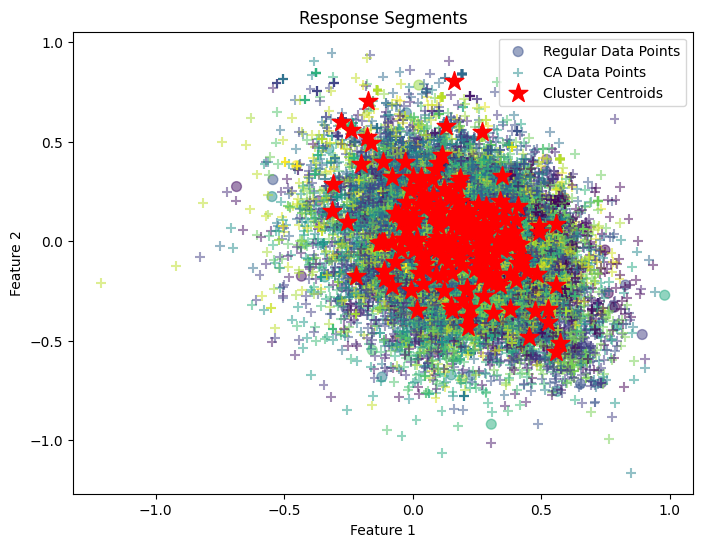

In [24]:
# Visualize the clusters
feature_1 = 98
feature_2 = 73


class_labels = [0] * 377 + [1] * 377
plt.figure(figsize=(8, 6))
plt.scatter(trimmed_combined_embeddings[:377, feature_1], trimmed_combined_embeddings[:377, feature_2], c=final_predictions[:377], s=50, cmap='viridis', alpha=0.5, label='Regular Data Points')
plt.scatter(trimmed_combined_embeddings[377:, feature_1], trimmed_combined_embeddings[377:, feature_2], c=final_predictions[377:], s=50, cmap='viridis', alpha=0.5, label='CA Data Points', marker="+")
plt.scatter(final_centroids[:,feature_1], final_centroids[:,feature_2], c='red', s=200, marker='*', label='Cluster Centroids')
plt.title('Response Segments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [36]:
gpt_count_per_cluster = [{}, {}, {}, {}, {}]
cagpt_count_per_cluster = [{}, {}, {}, {}, {}]

"""
4102
5416
3274
3100
3875

2035
2067
2709
2707
1405
1869
1268
1832
1775
2100
"""
lengths = [1217, 1281, 1623, 1700, 845, 1167, 774, 1145, 1076, 1261]

for j in range(5):
    for i in range(20):
        gpt_count_per_cluster[j][i] = 0
        cagpt_count_per_cluster[j][i] = 0
    for i in range(lengths[j*2]):
        gpt_count_per_cluster[j][final_predictions[j][i]] += 1
    for i in range(lengths[j*2], lengths[j*2] + lengths[j*2+1]):
        cagpt_count_per_cluster[j][final_predictions[j][i]] += 1

print(gpt_count_per_cluster)
print(cagpt_count_per_cluster)



[{0: 113, 1: 17, 2: 49, 3: 91, 4: 25, 5: 72, 6: 77, 7: 78, 8: 18, 9: 18, 10: 138, 11: 0, 12: 102, 13: 107, 14: 52, 15: 46, 16: 30, 17: 5, 18: 106, 19: 73}, {0: 178, 1: 72, 2: 128, 3: 94, 4: 39, 5: 27, 6: 93, 7: 123, 8: 2, 9: 57, 10: 66, 11: 41, 12: 160, 13: 126, 14: 131, 15: 60, 16: 102, 17: 107, 18: 3, 19: 14}, {0: 57, 1: 55, 2: 74, 3: 27, 4: 25, 5: 7, 6: 21, 7: 112, 8: 21, 9: 4, 10: 37, 11: 61, 12: 11, 13: 77, 14: 56, 15: 68, 16: 82, 17: 37, 18: 2, 19: 11}, {0: 13, 1: 75, 2: 22, 3: 38, 4: 68, 5: 22, 6: 3, 7: 35, 8: 17, 9: 13, 10: 30, 11: 53, 12: 30, 13: 51, 14: 101, 15: 10, 16: 97, 17: 40, 18: 46, 19: 10}, {0: 53, 1: 54, 2: 36, 3: 33, 4: 8, 5: 60, 6: 44, 7: 46, 8: 88, 9: 102, 10: 57, 11: 10, 12: 24, 13: 18, 14: 103, 15: 30, 16: 58, 17: 70, 18: 38, 19: 144}]
[{0: 26, 1: 29, 2: 41, 3: 101, 4: 121, 5: 99, 6: 71, 7: 59, 8: 55, 9: 85, 10: 54, 11: 32, 12: 82, 13: 24, 14: 132, 15: 43, 16: 34, 17: 73, 18: 72, 19: 48}, {0: 141, 1: 75, 2: 88, 3: 52, 4: 93, 5: 92, 6: 61, 7: 98, 8: 13, 9: 49, 10

In [38]:
#gpt_count_per_cluster = {0: 88, 1: 62, 2: 70, 3: 126, 4: 63, 5: 69, 6: 85, 7: 25, 8: 69, 9: 2, 10: 98, 11: 47, 12: 28, 13: 61, 14: 6, 15: 39, 16: 81, 17: 15, 18: 75, 19: 34, 20: 44, 21: 42, 22: 0, 23: 43, 24: 57, 25: 7, 26: 119, 27: 42, 28: 73, 29: 12, 30: 8, 31: 13, 32: 68, 33: 78, 34: 44, 35: 8, 36: 156, 37: 15, 38: 133, 39: 27, 40: 24, 41: 8, 42: 5, 43: 45, 44: 89, 45: 47, 46: 125, 47: 64, 48: 19, 49: 100, 50: 76, 51: 7, 52: 65, 53: 29, 54: 15, 55: 62, 56: 15, 57: 48, 58: 2, 59: 5, 60: 16, 61: 41, 62: 44, 63: 35, 64: 53, 65: 45, 66: 40, 67: 58, 68: 32, 69: 4, 70: 3, 71: 59, 72: 93, 73: 43, 74: 54, 75: 8, 76: 34, 77: 104, 78: 44, 79: 72, 80: 60, 81: 20, 82: 66, 83: 33, 84: 16, 85: 27, 86: 1, 87: 8, 88: 27, 89: 127, 90: 80, 91: 9, 92: 0, 93: 64, 94: 105, 95: 67, 96: 76, 97: 78, 98: 50, 99: 29, 100: 31, 101: 94, 102: 36, 103: 57, 104: 61, 105: 67, 106: 13, 107: 18, 108: 12, 109: 51, 110: 66, 111: 20, 112: 13, 113: 0, 114: 103, 115: 0, 116: 75, 117: 10, 118: 61, 119: 138, 120: 55, 121: 27, 122: 21, 123: 53, 124: 38, 125: 75, 126: 0, 127: 65, 128: 10, 129: 15, 130: 50, 131: 122, 132: 5, 133: 29, 134: 29, 135: 50, 136: 52, 137: 19, 138: 43, 139: 75, 140: 120, 141: 53, 142: 15, 143: 154, 144: 70, 145: 98, 146: 13, 147: 26, 148: 4, 149: 3, 150: 105, 151: 40, 152: 17, 153: 24, 154: 11, 155: 67, 156: 6, 157: 30, 158: 128, 159: 137, 160: 1, 161: 49, 162: 3, 163: 73, 164: 6, 165: 11, 166: 31, 167: 10, 168: 31, 169: 9, 170: 13, 171: 0, 172: 24, 173: 58, 174: 102, 175: 73, 176: 4, 177: 8, 178: 40, 179: 54, 180: 58, 181: 37, 182: 69, 183: 22, 184: 3, 185: 51, 186: 18, 187: 51, 188: 49, 189: 163, 190: 40, 191: 62, 192: 85, 193: 8, 194: 8, 195: 28, 196: 81, 197: 6, 198: 63, 199: 3}
#cagpt_count_per_cluster = {0: 70, 1: 38, 2: 98, 3: 170, 4: 46, 5: 41, 6: 28, 7: 126, 8: 42, 9: 22, 10: 24, 11: 11, 12: 95, 13: 37, 14: 70, 15: 6, 16: 42, 17: 104, 18: 43, 19: 31, 20: 81, 21: 27, 22: 103, 23: 31, 24: 33, 25: 2, 26: 35, 27: 43, 28: 22, 29: 58, 30: 76, 31: 17, 32: 39, 33: 46, 34: 66, 35: 31, 36: 46, 37: 75, 38: 58, 39: 117, 40: 83, 41: 41, 42: 43, 43: 55, 44: 67, 45: 72, 46: 57, 47: 31, 48: 30, 49: 20, 50: 42, 51: 26, 52: 37, 53: 69, 54: 50, 55: 44, 56: 55, 57: 77, 58: 106, 59: 56, 60: 44, 61: 1, 62: 25, 63: 52, 64: 44, 65: 3, 66: 21, 67: 27, 68: 36, 69: 43, 70: 95, 71: 8, 72: 58, 73: 59, 74: 35, 75: 101, 76: 74, 77: 117, 78: 33, 79: 34, 80: 25, 81: 8, 82: 70, 83: 30, 84: 58, 85: 131, 86: 102, 87: 50, 88: 15, 89: 55, 90: 84, 91: 27, 92: 12, 93: 35, 94: 19, 95: 23, 96: 45, 97: 96, 98: 121, 99: 46, 100: 48, 101: 50, 102: 14, 103: 52, 104: 29, 105: 23, 106: 45, 107: 22, 108: 2, 109: 40, 110: 33, 111: 53, 112: 35, 113: 9, 114: 82, 115: 5, 116: 34, 117: 39, 118: 74, 119: 129, 120: 18, 121: 4, 122: 117, 123: 70, 124: 9, 125: 32, 126: 7, 127: 28, 128: 59, 129: 38, 130: 20, 131: 74, 132: 32, 133: 118, 134: 85, 135: 46, 136: 63, 137: 55, 138: 97, 139: 60, 140: 45, 141: 121, 142: 71, 143: 73, 144: 44, 145: 114, 146: 130, 147: 50, 148: 101, 149: 33, 150: 8, 151: 62, 152: 52, 153: 75, 154: 88, 155: 52, 156: 33, 157: 30, 158: 24, 159: 94, 160: 59, 161: 16, 162: 17, 163: 93, 164: 12, 165: 102, 166: 27, 167: 52, 168: 43, 169: 64, 170: 117, 171: 37, 172: 60, 173: 30, 174: 145, 175: 34, 176: 22, 177: 95, 178: 2, 179: 39, 180: 21, 181: 42, 182: 91, 183: 48, 184: 20, 185: 110, 186: 18, 187: 31, 188: 30, 189: 47, 190: 51, 191: 32, 192: 96, 193: 95, 194: 93, 195: 86, 196: 75, 197: 29, 198: 152, 199: 19}
for j in range(5):
    results = {}
    for i in range(20):
        #print(str(i+1), str(cagpt_count_per_cluster[i]), "vs", gpt_count_per_cluster[i])
        if cagpt_count_per_cluster[j][i] + gpt_count_per_cluster[j][i] == 0:
            #print(str(i), "Empty")
            results[i] = -1
        else:
            #print(str(i), str((cagpt_count_per_cluster[j][i] - gpt_count_per_cluster[j][i])/(cagpt_count_per_cluster[j][i] + gpt_count_per_cluster[j][i])))
            results[i] = (gpt_count_per_cluster[j][i] - cagpt_count_per_cluster[j][i])/(cagpt_count_per_cluster[j][i] + gpt_count_per_cluster[j][i])
            #if i == 150:
                #print(cagpt_count_per_cluster[i], gpt_count_per_cluster[i])
    print(dict(sorted(results.items(), key=lambda item: item[1])))




{11: -1.0, 17: -0.8717948717948718, 4: -0.6575342465753424, 9: -0.6504854368932039, 8: -0.5068493150684932, 14: -0.43478260869565216, 1: -0.2608695652173913, 5: -0.15789473684210525, 16: -0.0625, 3: -0.052083333333333336, 15: 0.033707865168539325, 6: 0.04054054054054054, 2: 0.08888888888888889, 12: 0.10869565217391304, 7: 0.1386861313868613, 18: 0.19101123595505617, 19: 0.2066115702479339, 10: 0.4375, 0: 0.6258992805755396, 13: 0.6335877862595419}
{18: -0.8846153846153846, 8: -0.7333333333333333, 19: -0.631578947368421, 11: -0.6289592760180995, 5: -0.5462184873949579, 4: -0.4090909090909091, 12: -0.2176039119804401, 14: -0.033210332103321034, 1: -0.02040816326530612, 15: 0.0, 9: 0.07547169811320754, 7: 0.11312217194570136, 0: 0.11598746081504702, 2: 0.18518518518518517, 10: 0.1891891891891892, 6: 0.2077922077922078, 17: 0.2441860465116279, 3: 0.2876712328767123, 16: 0.4166666666666667, 13: 0.46511627906976744}
{18: -0.875, 12: -0.808695652173913, 5: -0.7586206896551724, 8: -0.658536585

In [71]:
gpt_one_dimension = [[],[],[],[],[]]
cagpt_one_dimension = [[],[],[],[],[]]
for i in range(len(gpt)):
    for j in range(len(gpt[i])):
        for question in gpt[i][j]:
                gpt_one_dimension[j].append(question)
for i in range(len(cagpt)):
    for j in range(5):
        for question in cagpt[i][j]:
                cagpt_one_dimension[j].append(question)



230
[' Right to access personal information', ' Right to rectify incorrect personal information', ' Right to erasure of personal information in certain situations']
1217
1281


In [77]:
subquestion_text_per_cluster = [[[] for _ in range(20)], [[] for _ in range(20)], [[] for _ in range(20)], [[] for _ in range(20)], [[] for _ in range(20)]]
for j in range(5):
    for i in range(len(gpt_one_dimension[j])):
        subquestion_text_per_cluster[j][final_predictions[j][i]].append("GPT: " + gpt_one_dimension[j][i])
    for i in range(len(cagpt_one_dimension[j])):
        subquestion_text_per_cluster[j][final_predictions[j][i + len(gpt_one_dimension[j])]].append("CAGPT: " + cagpt_one_dimension[j][i])
print(len(subquestion_text_per_cluster))



for j in range(5):
    # Define the filename
    filename = "C:/Users/laela/Downloads/question_" + str(j+1) + "_subquestion_text_per_cluster.txt"
    # Open the file in write mode
    with open(filename, "w") as file:
        # Iterate over each cluster
        for cluster_index, cluster_contents in enumerate(subquestion_text_per_cluster[j]):
            # Write the cluster index to the file
            file.write(f"Cluster {cluster_index}:\n")
            
            # Iterate over each item in the cluster
            for item in cluster_contents:
                # Write the item to the file
                try:
                    file.write(item + "\n")
                except UnicodeEncodeError as e:
                    file.write(item[0:4] + "UnicodeEncodeError occurred \n")
                    print(f"UnicodeEncodeError occurred: {e}", cluster_index)
                
            # Write a separator between clusters
            file.write("\n")

5
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 137: character maps to <undefined> 5
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 241: character maps to <undefined> 6
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 131: character maps to <undefined> 7
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 177: character maps to <undefined> 0
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 111: character maps to <undefined> 18
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 85: character maps to <undefined> 18
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 78: character maps to <undefined> 18
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 69: character maps to <undefined> 9
Unicod